# Section 20. The Euler method (cont'd)

from Chapter 2. Numerical Differentail Equation Methods in Butcher "Numerical methods for ordinary differential equations," 2nd ed., Wiley, 2008.

$$
\newcommand{\bv}[1]{\pmb{#1}}
\newcommand{\df}[2]{\frac{d #1}{d #2}}
\newcommand{\pf}[2]{\frac{\partial #1}{\partial #2}}
%
\newcommand{\pr}[1]{\!\left( #1 \right)}
%
\newcommand{\norm}[1]{\left\Vert #1 \right\Vert}
%
\newcommand{\pmat}[1]{\begin{pmatrix} #1 \end{pmatrix}} % \pmat{1 & 2 \\ 3 & 4}
\newcommand{\mat}[1]{\begin{matrix} #1 \end{matrix}}
%
\newcommand{\butcher}[2]{%
\begin{array}{c|cccccccc} #1 \\ \hline & #2 \end{array}%
}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from numba import njit, jit

In [2]:
class BaseSolver:
    def __init__(self, func, xlim, y0, n_steps, **kwargs):
        self.func = func
        self.xlim = xlim
        self.y0   = y0
        self.n_steps = n_steps
    
    def solve(self):
        self.x, self.y = self._solve(
            func = self.func,
            xlim = self.xlim,
            y0   = self.y0,
            n_steps = self.n_steps
        )
        return self

In [3]:
class Euler(BaseSolver):
    @staticmethod
    @njit
    def _solve(func, xlim, y0, n_steps):
        x = np.linspace(xlim[0], xlim[1], int(n_steps)).astype(np.float64)
        y = np.zeros(shape=(len(x), len(y0)), dtype=np.float64)
        y[0,:] = y0
        h = np.median(np.diff(x))
        
        for i in range(1, len(x)):
            y[i,:] = y[i-1,:] + h*func(x[i-1], y[i-1,:])
            
        return x, y

#### Butcher tableau
$h = x_{n} - x_{n-1}$とすると，2段のRunge-Kutta methodは一般に次のようにかける．
$$
\begin{align*}
Y_2 &= y_{n-1} + a_{21} \cdot h f(x_{n-1}, y_{n-1}) \\
y_n &= y_{n-1} + b_1 \cdot h f(x_{n-1}, y_{n-1}) + b_2 \cdot h f(x_{n-1}+c_2 h, Y_2)
\end{align*}
$$
これを，次のButcher tableauで表す．
$$
\butcher{0 \\ c_2 & a_{21} }{b_1 & b_2}
$$

#### RK21 (Trapezoidal rule)
$$
\butcher{0 \\ c_2 & a_{21} }{b_1 & b_2}
=
\butcher{0 \\ 1 & 1 }{\frac{1}{2} & \frac{1}{2}}
$$

#### RK22 (Mid-point rule)
$$
\butcher{0 \\ c_2 & a_{21} }{b_1 & b_2}
=
\butcher{0 \\ \frac{1}{2} & \frac{1}{2} }{0 & 1}
$$

In [4]:
class RK21(BaseSolver):
    @staticmethod
    @njit
    def _solve(func, xlim, y0, n_steps):
        x = np.linspace(xlim[0], xlim[1], int(n_steps)).astype(np.float64)
        y = np.zeros(shape=(len(x), len(y0)), dtype=np.float64)
        y[0,:] = y0
        h = np.median(np.diff(x))
        
        c2, a21 = 1, 1
        b1, b2 = 0.5, 0.5
        
        for i in range(1, len(x)):
            xold, xnew = x[i-1], x[i]
            yold = y[i-1,:]
            
            Y2 = yold + a21*h*func(xold, yold)
            ynew = yold + b1*h*func(xold, yold) + b2*h*func(xold+c2*h, Y2)
            
            y[i,:] = ynew
        return x, y

In [5]:
class RK22(BaseSolver):
    @staticmethod
    @njit
    def _solve(func, xlim, y0, n_steps):
        x = np.linspace(xlim[0], xlim[1], int(n_steps)).astype(np.float64)
        y = np.zeros(shape=(len(x), len(y0)), dtype=np.float64)
        y[0,:] = y0
        h = np.median(np.diff(x))
        
        c2, a21 = 0.5, 0.5
        b1, b2 = 0, 1
        
        for i in range(1, len(x)):
            xold, xnew = x[i-1], x[i]
            yold = y[i-1,:]
            
            Y2 = yold + a21*h*func(xold, yold)
            ynew = yold + b1*h*func(xold, yold) + b2*h*func(xold+c2*h, Y2)
            
            y[i,:] = ynew
        return x, y

#### RK31
$$
\butcher{0 \\ c_2 & a_{21} \\ c_3 & a_{31} & a_{32}}{b_1 & b_2 & b_3}
=
\butcher{0 \\ \frac{2}{3} & \frac{2}{3} \\ \frac{2}{3} & \frac{1}{3} & \frac{1}{3}}{\frac{1}{4} & 0 & \frac{3}{4}}
$$

#### RK32
$$
\butcher{0 \\ c_2 & a_{21} \\ c_3 & a_{31} & a_{32}}{b_1 & b_2 & b_3}
=
\butcher{0 \\ \frac{1}{2} & \frac{1}{2} \\ 1 & -1 & 2}{\frac{1}{6} & \frac{2}{3} & \frac{1}{6}}
$$

In [6]:
class RK31(BaseSolver):
    @staticmethod
    @njit
    def _solve(func, xlim, y0, n_steps):
        x = np.linspace(xlim[0], xlim[1], int(n_steps)).astype(np.float64)
        y = np.zeros(shape=(len(x), len(y0)), dtype=np.float64)
        y[0,:] = y0
        h = np.median(np.diff(x))
        
        c2, a21 = 2./3., 2./3.
        c3, a31, a32 = 2./3, 1./3., 1./3.
        b1, b2, b3 = 1./4., 0., 3./4.
        
        for i in range(1, len(x)):
            xold, xnew = x[i-1], x[i]
            yold = y[i-1,:]
            
            Y2 = yold + a21*h*func(xold, yold)
            Y3 = yold + a31*h*func(xold, yold) + a32*h*func(xold+c2*h, Y2)
            ynew = yold + b1*h*func(xold, yold) + b2*h*func(xold+c2*h, Y2) + b3*h*func(xold+c3*h, Y3)
            
            y[i,:] = ynew
        return x, y

In [7]:
class RK32(BaseSolver):
    @staticmethod
    @njit
    def _solve(func, xlim, y0, n_steps):
        x = np.linspace(xlim[0], xlim[1], int(n_steps)).astype(np.float64)
        y = np.zeros(shape=(len(x), len(y0)), dtype=np.float64)
        y[0,:] = y0
        h = np.median(np.diff(x))
        
        c2, a21 = 0.5, 0.5
        c3, a31, a32 = 1., -1., 2.
        b1, b2, b3 = 1./6., 2./3., 1./6.
        
        for i in range(1, len(x)):
            xold, xnew = x[i-1], x[i]
            yold = y[i-1,:]
            
            Y2 = yold + a21*h*func(xold, yold)
            Y3 = yold + a31*h*func(xold, yold) + a32*h*func(xold+c2*h, Y2)
            ynew = yold + b1*h*func(xold, yold) + b2*h*func(xold+c2*h, Y2) + b3*h*func(xold+c3*h, Y3)
            
            y[i,:] = ynew
        return x, y

#### RK41
$$
\butcher{0 \\ c_2 & a_{21} \\ c_3 & a_{31} & a_{32} \\ c_4 & a_{41} & a_{42} & a_{43} }{b_1 & b_2 & b_3 & b_4}
=
\butcher{0 \\ \frac{1}{2} & \frac{1}{2} \\ \frac{1}{2} & 0 & \frac{1}{2} \\ 1 & 0 & 0 & 1 }{\frac{1}{6} & \frac{1}{3} & \frac{1}{3} & \frac{1}{6}}
$$

#### RK42
$$
\butcher{0 \\ c_2 & a_{21} \\ c_3 & a_{31} & a_{32} \\ c_4 & a_{41} & a_{42} & a_{43} }{b_1 & b_2 & b_3 & b_4}
=
\butcher{0 \\ \frac{1}{4} & \frac{1}{4} \\ \frac{1}{2} & 0 & \frac{1}{2} \\ 1 & 1 & -2 & 2 }{\frac{1}{6} & 0 & \frac{2}{3} & \frac{1}{6}}
$$

In [8]:
class RK41(BaseSolver):
    @staticmethod
    @njit
    def _solve(func, xlim, y0, n_steps):
        x = np.linspace(xlim[0], xlim[1], int(n_steps)).astype(np.float64)
        y = np.zeros(shape=(len(x), len(y0)), dtype=np.float64)
        y[0,:] = y0
        h = np.median(np.diff(x))
        
        c2, a21 = 0.5, 0.5
        c3, a31, a32 = 0.5, 0.0, 0.5
        c4, a41, a42, a43 = 1.0, 0.0, 0.0, 1.0
        b1, b2, b3, b4 = 1./6., 1./3., 1./3., 1./6.
        
        for i in range(1, len(x)):
            xold, xnew = x[i-1], x[i]
            yold = y[i-1,:]
            
            Y2 = yold + a21*h*func(xold, yold)
            Y3 = yold + a31*h*func(xold, yold) + a32*h*func(xold+c2*h, Y2)
            Y4 = yold + a41*h*func(xold, yold) + a42*h*func(xold+c2*h, Y2) + a43*h*func(xold+c3*h, Y3)
            ynew = yold + b1*h*func(xold, yold) + b2*h*func(xold+c2*h, Y2) + b3*h*func(xold+c3*h, Y3) + b4*h*func(xold+c4*h, Y4)
            
            y[i,:] = ynew
        return x, y

In [9]:
class RK42(BaseSolver):
    @staticmethod
    @njit
    def _solve(func, xlim, y0, n_steps):
        x = np.linspace(xlim[0], xlim[1], int(n_steps)).astype(np.float64)
        y = np.zeros(shape=(len(x), len(y0)), dtype=np.float64)
        y[0,:] = y0
        h = np.median(np.diff(x))
        
        c2, a21 = 0.25, 0.25
        c3, a31, a32 = 0.5, 0.0, 0.5
        c4, a41, a42, a43 = 1.0, 1.0, -2., 2.
        b1, b2, b3, b4 = 1./6., 0., 2./3., 1./6.
        
        for i in range(1, len(x)):
            xold, xnew = x[i-1], x[i]
            yold = y[i-1,:]
            
            Y2 = yold + a21*h*func(xold, yold)
            Y3 = yold + a31*h*func(xold, yold) + a32*h*func(xold+c2*h, Y2)
            Y4 = yold + a41*h*func(xold, yold) + a42*h*func(xold+c2*h, Y2) + a43*h*func(xold+c3*h, Y3)
            ynew = yold + b1*h*func(xold, yold) + b2*h*func(xold+c2*h, Y2) + b3*h*func(xold+c3*h, Y3) + b4*h*func(xold+c4*h, Y4)
            
            y[i,:] = ynew
        return x, y

#### RK5
$$
\butcher{
0 \\ 
c_2 & a_{21} \\ 
c_3 & a_{31} & a_{32} \\ 
c_4 & a_{41} & a_{42} & a_{43} \\ 
c_5 & a_{51} & a_{52} & a_{53} & a_{54} \\
c_6 & a_{61} & a_{62} & a_{63} & a_{64} & a_{65}
}{
b_1 & b_2 & b_3 & b_4 & b_5 & b_6
}
=
% \butcher{0 \\ \frac{1}{2} & \frac{1}{2} \\ \frac{1}{2} & 0 & \frac{1}{2} \\ 1 & 0 & 0 & 1 }{\frac{1}{6} & \frac{1}{3} & \frac{1}{3} & \frac{1}{6}}
\butcher{
0 \\
\frac{1}{4} & \frac{1}{4} \\
\frac{1}{4} & \frac{1}{8} & \frac{1}{8} \\
\frac{1}{2} & 0 & 0 & \frac{1}{2} \\
\frac{3}{4} & \frac{3}{16} & -\frac{3}{8} & \frac{3}{8} & \frac{9}{16} \\
1 & -\frac{3}{7} & \frac{8}{7} & \frac{6}{7} & -\frac{12}{7} & \frac{8}{7}
}{
\frac{7}{90} & 0 & \frac{32}{90} & \frac{12}{90} & \frac{32}{90} & \frac{7}{90}
}
$$

In [10]:
class RK5(BaseSolver):
    @staticmethod
    @njit
    def _solve(func, xlim, y0, n_steps):
        x = np.linspace(xlim[0], xlim[1], int(n_steps)).astype(np.float64)
        y = np.zeros(shape=(len(x), len(y0)), dtype=np.float64)
        y[0,:] = y0
        h = np.median(np.diff(x))
        
        c2, a21 = 0.25, 0.25
        c3, a31, a32 = 0.25, 0.125, 0.125
        c4, a41, a42, a43 = 0.5, 0., 0., 0.5
        c5, a51, a52, a53, a54 = 3./4., 3./16, -3./8, 3./8, 9./16
        c6, a61, a62, a63, a64, a65 = 1.0, -3./7., 8./7., 6./7., -12./7., 8./7.
        b1, b2, b3, b4, b5, b6 = 7./90., 0., 32./90., 12./90., 32./90., 7./90.
        
        for i in range(1, len(x)):
            xold, xnew = x[i-1], x[i]
            yold = y[i-1,:]
            
            Y2 = yold + a21*h*func(xold, yold)
            Y3 = yold + a31*h*func(xold, yold) + a32*h*func(xold+c2*h, Y2)
            Y4 = yold + a41*h*func(xold, yold) + a42*h*func(xold+c2*h, Y2) + a43*h*func(xold+c3*h, Y3)
            Y5 = yold + a51*h*func(xold, yold) + a52*h*func(xold+c2*h, Y2) + a53*h*func(xold+c3*h, Y3) + a54*h*func(xold+c4*h, Y4)
            Y6 = yold + a61*h*func(xold, yold) + a62*h*func(xold+c2*h, Y2) + a63*h*func(xold+c3*h, Y3) + a64*h*func(xold+c4*h, Y4) + a65*h*func(xold+c5*h, Y5)
            ynew = yold + b1*h*func(xold, yold) + b2*h*func(xold+c2*h, Y2) + b3*h*func(xold+c3*h, Y3) + b4*h*func(xold+c4*h, Y4) + b5*h*func(xold+c5*h, Y5) + b6*h*func(xold+c6*h, Y6)
            
            y[i,:] = ynew
        return x, y

In [11]:
class Problem2:
    def __init__(self, e=0.0):
        self.e = e
        
        self.xlim = np.array([0.0, np.pi], dtype=np.float64)
        self.y0 = np.array([1.-e, 0., 0., np.sqrt((1.+e)/(1.-e))], dtype=np.float64)
        self.y_end_exact = np.array([-1.-e, 0., 0., -np.sqrt((1.-e)/(1.+e))], dtype=np.float64)
        
    def y0y1_exact(self, x):
        e = self.e
        r = (1.-e**2) / (1.+e*np.cos(x))
#         y_exact = np.vstack([r*np.cos(x), r*np.sin(x)]).T
        y0_exact = r*np.cos(x)
        y1_exact = r*np.sin(x)
        return y0_exact, y1_exact
    
    @staticmethod
    @njit
    def func(x, y):
        C = (y[0]**2 + y[1]**2)**(-3./2.)
        dydx = np.array([
             y[2],
             y[3],
            -y[0]*C,
            -y[1]*C,
        ], dtype=np.float64)
        return dydx

In [12]:
problem = Problem2(e=0.5)
n_steps = 10
%time solver = Euler(func=problem.func, xlim=problem.xlim, y0=problem.y0, n_steps=n_steps).solve()

Wall time: 2.78 s


In [13]:
%time solver21 = RK21(func=problem.func, xlim=problem.xlim, y0=problem.y0, n_steps=n_steps).solve()
%time solver22 = RK22(func=problem.func, xlim=problem.xlim, y0=problem.y0, n_steps=n_steps).solve()

Wall time: 813 ms
Wall time: 870 ms


In [14]:
%time solver31 = RK31(func=problem.func, xlim=problem.xlim, y0=problem.y0, n_steps=n_steps).solve()
%time solver32 = RK32(func=problem.func, xlim=problem.xlim, y0=problem.y0, n_steps=n_steps).solve()

Wall time: 898 ms
Wall time: 959 ms


In [15]:
%time solver41 = RK41(func=problem.func, xlim=problem.xlim, y0=problem.y0, n_steps=n_steps).solve()
%time solver42 = RK42(func=problem.func, xlim=problem.xlim, y0=problem.y0, n_steps=n_steps).solve()
%time solver5 = RK5(func=problem.func, xlim=problem.xlim, y0=problem.y0, n_steps=n_steps).solve()

Wall time: 1.04 s
Wall time: 1.12 s
Wall time: 1.51 s


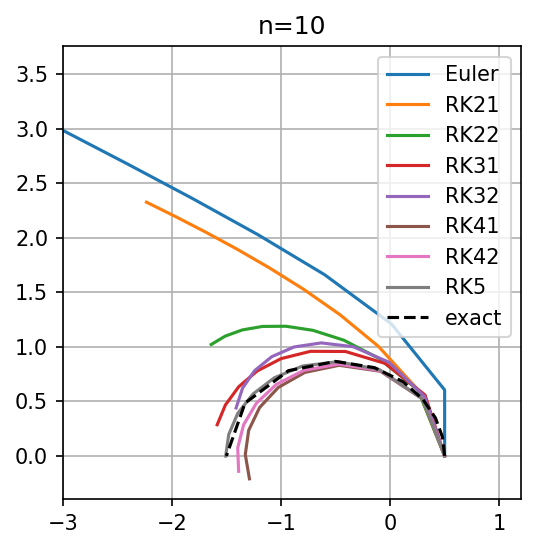

In [16]:
fig, ax = plt.subplots(dpi=150)
ax.plot(solver.y[:,0], solver.y[:,1], label="Euler")
ax.plot(solver21.y[:,0], solver21.y[:,1], label="RK21")
ax.plot(solver22.y[:,0], solver22.y[:,1], label="RK22")
ax.plot(solver31.y[:,0], solver31.y[:,1], label="RK31")
ax.plot(solver32.y[:,0], solver32.y[:,1], label="RK32")
ax.plot(solver41.y[:,0], solver41.y[:,1], label="RK41")
ax.plot(solver42.y[:,0], solver42.y[:,1], label="RK42")
ax.plot(solver5.y[:,0], solver5.y[:,1], label="RK5")

y0exact, y1exact = problem.y0y1_exact(solver.x)
ax.plot(y0exact, y1exact, 'k--', label='exact')

ax.set_title(f"n={solver.n_steps}")
ax.set_xlim(-3, 1.2)
# ax.set_ylim(-0.2, 1.2)
ax.legend()
ax.grid(which='both')
ax.set_aspect('equal')

In [17]:
solvers = dict(Euler=Euler, RK21=RK21, RK22=RK22, RK31=RK31, RK32=RK32, RK41=RK41, RK42=RK42, RK5=RK5)
results = dict()
for name, Solver in solvers.items():
    print(name)
    ns, errors = [], []
    for n_steps in (10.**np.arange(1, 6.1, 0.5)).astype(int):
        print(name, n_steps, end=':')
        %time solver1 = Solver(func=problem.func, xlim=problem.xlim, y0=problem.y0, n_steps=n_steps).solve()
        
        ns.append(solver1.n_steps)
        errors.append(np.linalg.norm(problem.y_end_exact - solver1.y[-1,:]))
    ns, errors = np.array(ns), np.array(errors)
    results.update({name: dict(ns=ns, errors=errors)})

Euler
Euler 10:Wall time: 829 ms
Euler 31:Wall time: 0 ns
Euler 100:Wall time: 0 ns
Euler 316:Wall time: 0 ns
Euler 1000:Wall time: 0 ns
Euler 3162:Wall time: 1.01 ms
Euler 10000:Wall time: 2 ms
Euler 31622:Wall time: 8.94 ms
Euler 100000:Wall time: 27 ms
Euler 316227:Wall time: 84.7 ms
Euler 1000000:Wall time: 259 ms
RK21
RK21 10:Wall time: 874 ms
RK21 31:Wall time: 978 µs
RK21 100:Wall time: 0 ns
RK21 316:Wall time: 1.01 ms
RK21 1000:Wall time: 996 µs
RK21 3162:Wall time: 3 ms
RK21 10000:Wall time: 6.97 ms
RK21 31622:Wall time: 19 ms
RK21 100000:Wall time: 61.8 ms
RK21 316227:Wall time: 197 ms
RK21 1000000:Wall time: 620 ms
RK22
RK22 10:Wall time: 819 ms
RK22 31:Wall time: 0 ns
RK22 100:Wall time: 0 ns
RK22 316:Wall time: 0 ns
RK22 1000:Wall time: 997 µs
RK22 3162:Wall time: 1.99 ms
RK22 10000:Wall time: 6.98 ms
RK22 31622:Wall time: 18.9 ms
RK22 100000:Wall time: 60.8 ms
RK22 316227:Wall time: 194 ms
RK22 1000000:Wall time: 630 ms
RK31
RK31 10:Wall time: 969 ms
RK31 31:Wall time: 99

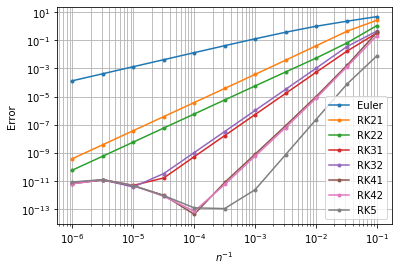

In [18]:
fig, ax = plt.subplots()
for name, res in results.items():
    ns1, errors1 = res['ns'], res['errors']
    ax.loglog(1./ns1, errors1, '.-', label=name)
ax.set_xlabel(r'$n^{-1}$')
ax.set_ylabel('Error')
ax.grid(which='both')
ax.legend()